**NEURAL NETWORK**

+ We'll use the model `NeuralNetwork` from `tensorflow`.
+ **Advantages of this model**
    + **Feature Interactions:** The selected features include a mix of numerical and categorical variables. Neural networks can effectively handle both types of features and capture interactions between them, which is crucial when dealing with diverse types of data.
    + **Representation Learning:** Neural networks have the ability to automatically learn hierarchical representations of the input data. This is advantageous when dealing with categorical variables because the model can learn meaningful representations rather than relying on handcrafted feature engineering.

**Import necessary libraries**

In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from itertools import product
import numpy as np
import seaborn as sns

2023-12-28 23:23:43.042367: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-28 23:23:43.072016: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-28 23:23:43.139195: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-28 23:23:43.139229: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-28 23:23:43.141556: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

**Preprocessing**

In [3]:
data = pd.read_csv('../Data/processed_data.csv')
data.head()

,name,general,specify,enrollment,language,rating,level,duration,instructor,instructor_rate,offered by
0,Cyber Threat Intelligence,Information Technology,Security,52299,English,4.7,Beginner,25,IBM Skills Network Team,4.5,IBM
1,Network Security,Information Technology,Security,6909,English,4.7,Beginner,8,(ISC)² Education & Training,4.9,ISC2
2,Security Principles,Information Technology,Security,12400,English,4.7,Beginner,5,(ISC)² Education & Training,4.6,ISC2
3,"Grow Your Business with Goldman Sachs 10,000 W...",Business,Entrepreneurship,50738,English,4.8,Other,4,NaN,4.7,NaN
4,"Fundamentals of Negotiation, with Goldman Sach...",Business,Entrepreneurship,20097,English,4.6,Other,4,"Mori Taheripour, Goldman Sachs 10,000 Women, E...",4.6,Goldman Sachs


In [4]:
# define numerical and categorical features
numerical_features = ['enrollment', 'duration', 'instructor_rate']
categorical_features = ['general', 'specify', 'language', 'level', 'instructor', 'offered by']

# select specific features
selected_features = ['enrollment', 'duration', 'instructor_rate', 'general', 'specify', 'language', 'level', 'instructor', 'offered by']
# handle missing values
data.dropna(subset=numerical_features+['rating'], inplace=True)

**Train, Validation, Test set splitting**
+ We'll perform splitting on the following ratio (70/20/10)

In [5]:
# select features and target variable
X = data[selected_features]
y = data['rating']

# split the data into training, testing, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

**Transformer**

In [6]:
# create transformers for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore'))
])

# combine transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [7]:
# fit the ColumnTransformer on the training data
preprocessor.fit(X_train)

/home/dylan/miniconda3/envs/min_ds-env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['enrollment', 'duration', 'instructor_rate']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['general', 'specify', 'language', 'level',
                                  'instructor', 'offered by'])])

**Hyperparameter tuning**
+ We'll perform hyperparameter tuning on two hyperparameters: learning_rate and batch_size.
+ We'll record the mean_squared_error of every combination of these parameters on the validation set.
+ Finally, we'll plot the corresponding heatmap.

**Model Layers**
+ Input Layer:
    + Type: Dense
    + Number of Neurons: 64
    + Activation Function: ReLU
    + Input Dimension: preprocessor.transform(X_train).shape[1]
    + This layer is the first hidden layer with ReLU activation.
+ Hidden Layer:
    + Type: Dense
    + Number of Neurons: 32
    + Activation Function: ReLU
    + This is the second hidden layer with ReLU activation.
+ Output Layer:
    + Type: Dense
    + Number of Neurons: 1
    + Activation Function: Linear
    + This is the output layer with a linear activation function, suitable for regression tasks.

In [8]:
# combine preprocessing with model training in a pipeline
modelNN = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Sequential([
        Dense(64, activation='relu', input_dim=preprocessor.transform(X_train).shape[1]),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ]))
])

**Optimizer**

+ Using Adam optimizer for Neural Network Model

In [9]:
# hyperparameters
learning_rates = [0.001, 0.002, 0.003, 0.004, 0.005]
batch_size = [50, 75, 100, 125, 150]

# compile the Keras model with specified learning rate
results = np.zeros((5, 5))
for rate, bat in product(learning_rates, batch_size):
    optimizer = Adam(learning_rate=rate)
    modelNN.named_steps['regressor'].compile(optimizer=optimizer, loss='mean_squared_error')

    # train the model with a reduced number of epochs
    modelNN.named_steps['regressor'].fit(
        preprocessor.transform(X_train), y_train,
        epochs=50, batch_size=bat,verbose=0)

    # testing on the validation set and record error
    y_val_pred = modelNN.predict(X_val)
    error = mean_squared_error(y_val, y_val_pred)
    results[learning_rates.index(rate)][batch_size.index(bat)] = error

18/18 [==============================] - 0s 2ms/step


/home/dylan/miniconda3/envs/min_ds-env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


18/18 [==============================] - 0s 2ms/step


/home/dylan/miniconda3/envs/min_ds-env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


18/18 [==============================] - 0s 1ms/step


/home/dylan/miniconda3/envs/min_ds-env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


18/18 [==============================] - 0s 2ms/step


/home/dylan/miniconda3/envs/min_ds-env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/dylan/miniconda3/envs/min_ds-env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


18/18 [==============================] - 0s 2ms/step


/home/dylan/miniconda3/envs/min_ds-env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


18/18 [==============================] - 0s 2ms/step


/home/dylan/miniconda3/envs/min_ds-env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


18/18 [==============================] - 0s 2ms/step


/home/dylan/miniconda3/envs/min_ds-env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/dylan/miniconda3/envs/min_ds-env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


18/18 [==============================] - 0s 3ms/step


/home/dylan/miniconda3/envs/min_ds-env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


18/18 [==============================] - 0s 5ms/step


/home/dylan/miniconda3/envs/min_ds-env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


18/18 [==============================] - 0s 5ms/step


/home/dylan/miniconda3/envs/min_ds-env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


18/18 [==============================] - 0s 4ms/step


/home/dylan/miniconda3/envs/min_ds-env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


18/18 [==============================] - 0s 4ms/step


/home/dylan/miniconda3/envs/min_ds-env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


18/18 [==============================] - 0s 4ms/step


/home/dylan/miniconda3/envs/min_ds-env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


18/18 [==============================] - 0s 4ms/step


/home/dylan/miniconda3/envs/min_ds-env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


18/18 [==============================] - 0s 7ms/step


/home/dylan/miniconda3/envs/min_ds-env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


18/18 [==============================] - 0s 4ms/step


/home/dylan/miniconda3/envs/min_ds-env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


18/18 [==============================] - 0s 4ms/step


/home/dylan/miniconda3/envs/min_ds-env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


18/18 [==============================] - 0s 4ms/step


/home/dylan/miniconda3/envs/min_ds-env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


 1/18 [>.............................] - ETA: 1s

/home/dylan/miniconda3/envs/min_ds-env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


 1/18 [>.............................] - ETA: 1s

/home/dylan/miniconda3/envs/min_ds-env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


18/18 [==============================] - 0s 4ms/step


/home/dylan/miniconda3/envs/min_ds-env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


18/18 [==============================] - 0s 4ms/step


/home/dylan/miniconda3/envs/min_ds-env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


18/18 [==============================] - 0s 4ms/step


/home/dylan/miniconda3/envs/min_ds-env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


18/18 [==============================] - 0s 4ms/step


**Plotting the heatmap**

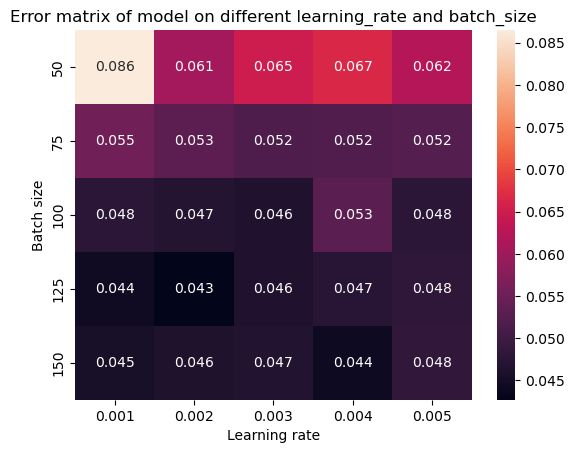

In [10]:
sns.heatmap(results, xticklabels=learning_rates, yticklabels=batch_size, annot=True)
plt.xlabel('Learning rate')
plt.ylabel('Batch size')
plt.title('Error matrix of model on different learning_rate and batch_size')
plt.show()

So, the best hyperparameters are learning_rate = 0.002 and batch_size = 50.

**Training and Testing/Evaluation**
+ We perform fitting on training + validation set.
+ Use squared error as the loss function.

In [11]:
# training
best_lr=0.001
best_bz=50

optimizer = Adam(learning_rate=best_lr)
modelNN.named_steps['regressor'].compile(optimizer=optimizer, loss='mean_squared_error')

history=modelNN.named_steps['regressor'].fit(
        preprocessor.transform(pd.concat([X_train,X_val])), pd.concat([y_train,y_val]),
        epochs=50, batch_size=best_bz,verbose=0)

/home/dylan/miniconda3/envs/min_ds-env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


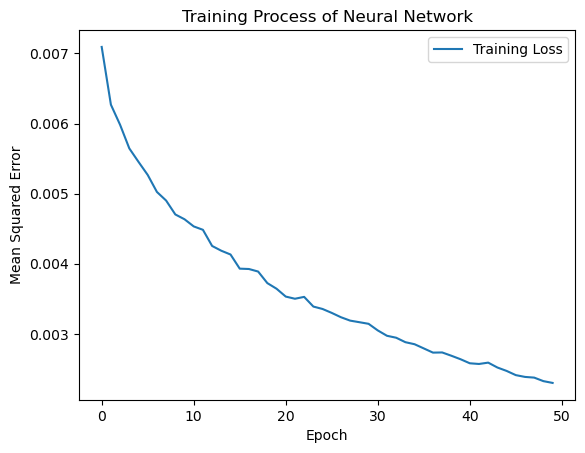

In [12]:
# visualize training loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training Process of Neural Network')
plt.legend()
plt.show()

In [13]:
# testing
y_test_pred = modelNN.predict(X_test)
nn_mse = mean_squared_error(y_test, y_test_pred)
print("MSE:", nn_mse)

/home/dylan/miniconda3/envs/min_ds-env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [2, 4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


36/36 [==============================] - 0s 3ms/step
MSE: 0.04968084141349296
